In [14]:
# Import packages
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns

In [15]:
# Path to ./data/processed folder
path_data_processed = os.path.join(
    os.path.abspath('../'),
    'data',
    'processed'
)

# Load Data

In [16]:
# Read dataset with AAPL's historic stock prices
df_stocks = pd.read_csv(
    os.path.join(
        path_data_processed,
        'stock_prices_appl.csv'
    ),
    index_col=0
)

# Apply pivot_table
df_stocks = df_stocks.pivot_table(
    values='Close',
    index='Date',
    columns='Stock'
).reset_index(drop=False)

In [17]:
# Read dataset with News' score
df_agg = pd.read_csv(
    os.path.join(
        path_data_processed,
        'reddit_news_avg_score_per_label.csv'
    )
)

In [18]:
# Merge both dataframes on date
df = df_stocks.merge(df_agg, on='Date', how='left')

# Create target column by shifting stock prices
df[f'AAPL_target'] = df['AAPL'].shift(1)

# Data Preparation

In [19]:
# Drop columns
data = df.drop([
    'Date',
    'AMZN',
    'GOOGL',
    'MSFT',
    'NVDA'
    ], axis=1)

# Fill NaN with 0, because there wasn't any news with this label
data['positive'] = data['positive'].fillna(0)
data['negative'] = data['negative'].fillna(0)

# Drop null values
data = data.dropna()

## Train-Test Split

In [20]:
# Set train percentage
train_percentage = 0.95

# Compute lenght of train dataframe
train_len = int(len(data) * train_percentage)

In [21]:
# Create data_train and data_test:
df_train = data.iloc[:train_len]
df_test = data.iloc[train_len:]

<Axes: xlabel='AAPL_target'>

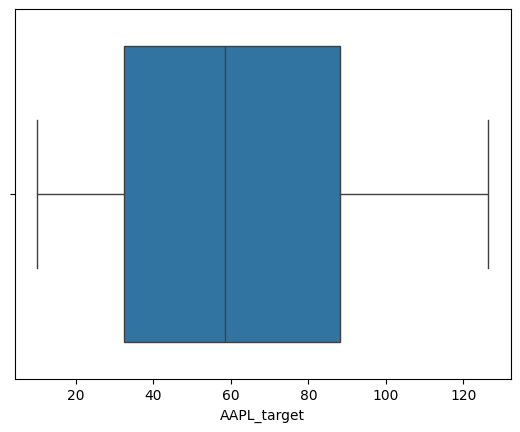

In [22]:
sns.boxplot(data=data, x='AAPL_target')

## Scaling
Transforming numerical features into a common smaller range

In [23]:
# Define features to be scaled
features_scale = ['AAPL']

# Define target columns
target = ['AAPL_target']

# Train MinMaxScaler to apply on the target columns
target_scaler = MinMaxScaler().fit(df_train[target])

# Apply scaler on train and test dataframes
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

# Train MinMaxScaler to apply on the feature columns
features_scaler = MinMaxScaler().fit(df_train[features_scale])

# Apply scaler on train and test dataframes
df_train[features_scale] = features_scaler.transform(df_train[features_scale])
df_test[features_scale] = features_scaler.transform(df_test[features_scale])

/tmp/ipykernel_305805/1299088375.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target] = target_scaler.transform(df_train[target])
/tmp/ipykernel_305805/1299088375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target] = target_scaler.transform(df_test[target])
/tmp/ipykernel_305805/1299088375.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## Subsequences

In [25]:
# Define funtion to create subsequences
def subsequence(df, length, features, target):
    # Initialize variables
    X, y = [], []

    # Iterate over the dataframe to create subsequences
    for i in range(length, df.shape[0]):
        X.append(df[features].iloc[i - length: i])
        y.append(df[target].iloc[i])

    # Convert X and y into arrays
    X = np.array(X)
    y = np.expand_dims(
        np.array(y).astype(np.float32),
        axis=-1
    )

    return X, y

In [ ]:
# Create subsequence with 5 business days X 4 weeks X 3 months
length = 5 * 4 * 3

features = [
    'AAPL',
    'negative',
    'neutral',
    'positive'
]

# Create train subsequences
X_train, y_train = subsequence(df_train, length, features, target)

# Create test subsequences
X_test, y_test = subsequence(df_test, length, features, target)

# RNN Model

In [30]:
# Padding train and test
X_train_pad = pad_sequences(X_train, value=-999, padding='post', dtype='float64')
X_test_pad = pad_sequences(X_test, value=-999, padding='post', dtype='float64')

In [31]:
# Build the model
def rnn_model():
    model = Sequential()

    model.add(layers.Masking(mask_value=-999))

    model.add(
        layers.LSTM(
            units=128,
            return_sequences = True,
            activation = "tanh",
            input_shape = X_train_pad[0].shape
        )
    )

    model.add(
        layers.LSTM(
            units=64,
            return_sequences = False,
            activation = "tanh"
        )
    )

    model.add(layers.Dense(25, activation="relu"))

    model.add(layers.Dense(1, activation="relu"))

    my_mae = metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

    model.compile(
        loss="mse",
        optimizer = "rmsprop",
        metrics = [my_mae, 'accuracy']
    )

    return model

model = rnn_model()

/home/nathalia/.pyenv/versions/3.10.6/envs/stocks_vs_behavior/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
%%time

es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")

history = model.fit(
    X_train_pad,
    # np.array(y_train),
    np.expand_dims(np.array(y_train), -1),
    validation_split = 0.3,
    batch_size=16,
    epochs=300,
    verbose = 1,
    callbacks = [es],
)

Epoch 1/300


2024-06-08 12:32:01.082677: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.0011 - loss: 0.0433 - mean_absolute_error: 0.1721 - val_accuracy: 0.0000e+00 - val_loss: 0.1891 - val_mean_absolute_error: 0.4093
Epoch 2/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 5.4499e-04 - loss: 0.0350 - mean_absolute_error: 0.1576 - val_accuracy: 0.0000e+00 - val_loss: 0.1963 - val_mean_absolute_error: 0.4188
Epoch 3/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 6.0294e-04 - loss: 0.0357 - mean_absolute_error: 0.1600 - val_accuracy: 0.0000e+00 - val_loss: 0.2067 - val_mean_absolute_error: 0.4304
Epoch 4/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.0017 - loss: 0.0342 - mean_absolute_error: 0.1553 - val_accuracy: 0.0000e+00 - val_loss: 0.1628 - val_mean_absolute_error: 0.3764
Epoch 5/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 3.6406e-04 - loss: 0.0346 - mean_absolute_error: 0.1576 - val_accuracy: 0.0000e+00 - val_loss: 0.2182 - val_mean_absolute_error: 0.4438
Epoch 6/30

In [35]:
for i in history.history.keys():
    value = np.mean(history.history[i])
    print(i, " = ", value)

accuracy  =  0.0007645260193385184
loss  =  0.03383500668509253
mean_absolute_error  =  0.15537569800327564
val_accuracy  =  0.0
val_loss  =  0.2201363156581747
val_mean_absolute_error  =  0.44474604931370965


In [37]:
def plot_loss_mae(history):

    fig, ax =plt.subplots(1,2,figsize=(20,5))

    # --- LOSS

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    plt.show()

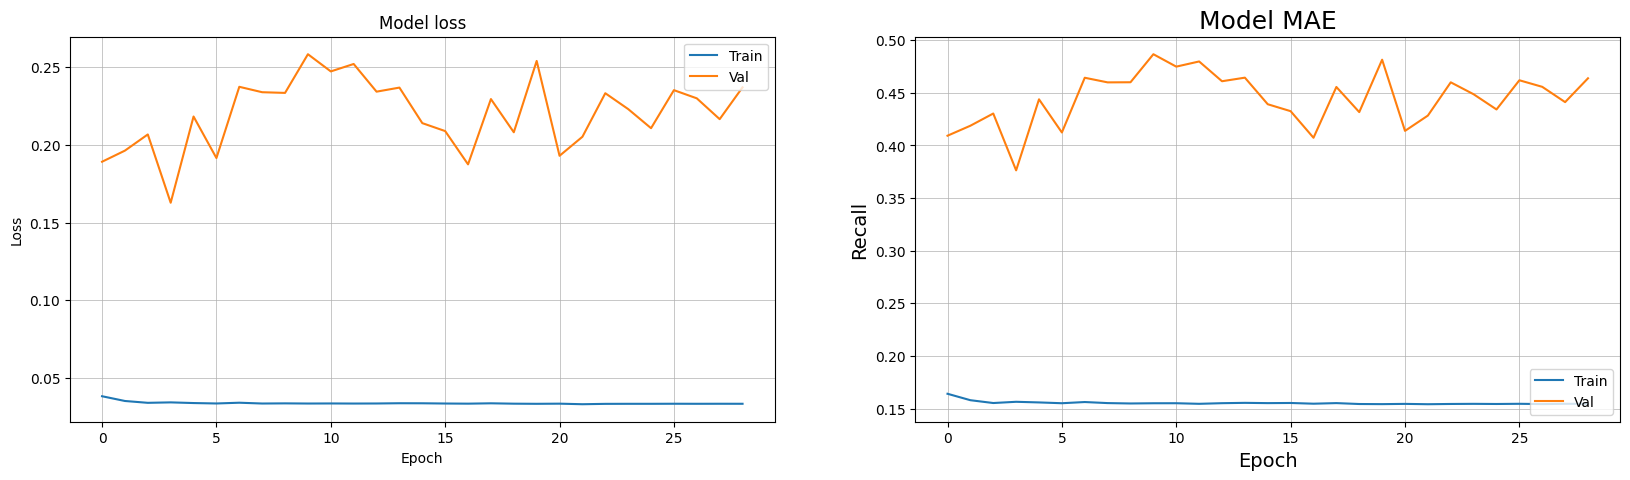

In [38]:
plot_loss_mae(history)

In [53]:
y_pred = target_scaler.inverse_transform(model.predict(X_test_pad))
y_test2 = np.array(y_test)[:, 0, 0]

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


In [43]:
r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test_pad))
r2

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


-350.0702209472656